In [1]:
# Read Image
import numpy as np
import skimage
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

#Predict class for image using InceptionV3
import keras
from keras.applications.imagenet_utils import decode_predictions
np.random.seed(222)
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes
decode_predictions(preds)[0] #Print top 5 classes

Using TensorFlow backend.


40960/35363 [==================================] - 0s 0us/step


[('n02099712', 'Labrador_retriever', 0.82710207),
 ('n02099601', 'golden_retriever', 0.014668807),
 ('n02093428', 'American_Staffordshire_terrier', 0.009347252),
 ('n02108422', 'bull_mastiff', 0.0091491),
 ('n02109047', 'Great_Dane', 0.008585929)]

[1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1
 0 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0]


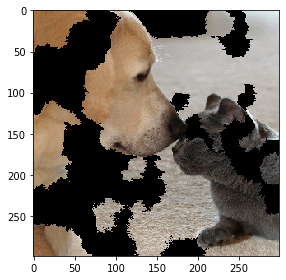

In [2]:
#Generate segmentation for image
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [3]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

(150, 1, 1000)


In [4]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

(150,)
(150,)


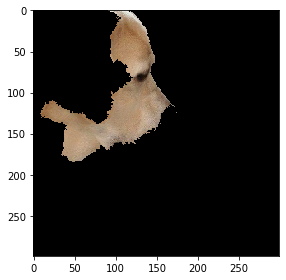

In [5]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0] #Labrador class
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))